## We use the VAE from vae.py to try to gain similar performance as in my project.

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

from sklearn.decomposition import PCA

import pandas as pd
import numpy as np
import seaborn as sbs

# Configure the device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using '{device}' device.")

# Set some seeds.
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

# Import the code I have written.
from Data import Data, CustomDataset, ToTensor
from vae import VAE, train

Using 'cuda' device.


In [2]:
# Load the data.
adult_data = pd.read_csv("adult_data_no_NA.csv", index_col = 0)
print(adult_data.shape) # Looks good!

categorical_features = ["workclass","marital_status","occupation","relationship", \
                        "race","sex","native_country"]
numerical_features = ["age","fnlwgt","education_num","capital_gain","capital_loss","hours_per_week"]

# Make Adult Dataclass. 
Adult = Data(adult_data, categorical_features, numerical_features, valid = False, splits = [6/7, 1/7])

# Load the preprocessed data. 
X_train_prep, y_train = Adult.get_training_data_preprocessed()
X_test_prep, y_test = Adult.get_test_data_preprocessed()
#X_valid_prep, y_valid = Adult.get_validation_data_preprocessed()

# Load the original data to have for later. 
X_train_og, _  = Adult.get_training_data()
X_test_og, _  = Adult.get_test_data()
#X_valid_og, _ = Adult.get_validation_data()

# Make training data for Pytorch. 
train_data = CustomDataset(X_train_prep, y_train, transform = ToTensor())

(45222, 14)


In [3]:
# Set some hyperparameters.
batch_size = 16 
input_size = X_train_prep.shape[1]
latent_dim = 8

# Define the training data loader. 
train_data_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 2)

In [4]:
autoencoder = VAE(input_size, latent_dim).to(device)
autoencoder

VAE(
  (encoder): VariationalEncoder(
    (l1): Linear(in_features=88, out_features=15, bias=True)
    (l2): Linear(in_features=15, out_features=8, bias=True)
    (l3): Linear(in_features=15, out_features=8, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (l1): Linear(in_features=8, out_features=15, bias=True)
    (l2): Linear(in_features=15, out_features=88, bias=True)
    (relu): ReLU()
  )
)

In [5]:
autoencoder, train_losses = train(autoencoder, train_data_loader, epochs = 15, device = device)

Epoch [1/30], Step [500/2423], Loss: 183.3329
Epoch [1/30], Step [1000/2423], Loss: 124.6566
Epoch [1/30], Step [1500/2423], Loss: 136.9940
Epoch [1/30], Step [2000/2423], Loss: 127.3736
Epoch [2/30], Step [500/2423], Loss: 170.1582
Epoch [2/30], Step [1000/2423], Loss: 112.8957
Epoch [2/30], Step [1500/2423], Loss: 119.7689
Epoch [2/30], Step [2000/2423], Loss: 120.2973
Epoch [3/30], Step [500/2423], Loss: 123.9818
Epoch [3/30], Step [1000/2423], Loss: 131.8948
Epoch [3/30], Step [1500/2423], Loss: 127.5107
Epoch [3/30], Step [2000/2423], Loss: 114.7451
Epoch [4/30], Step [500/2423], Loss: 117.8331
Epoch [4/30], Step [1000/2423], Loss: 157.8369
Epoch [4/30], Step [1500/2423], Loss: 97.0654
Epoch [4/30], Step [2000/2423], Loss: 103.9569
Epoch [5/30], Step [500/2423], Loss: 148.4948
Epoch [5/30], Step [1000/2423], Loss: 154.6704
Epoch [5/30], Step [1500/2423], Loss: 132.2226
Epoch [5/30], Step [2000/2423], Loss: 107.0674
Epoch [6/30], Step [500/2423], Loss: 132.4993
Epoch [6/30], Step [

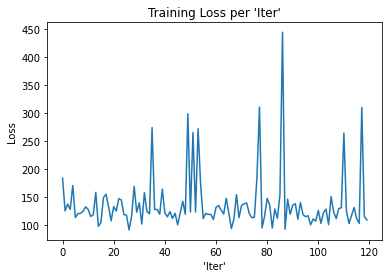

In [6]:
plt.plot(train_losses)
plt.title("Training Loss per 'Iter'")
plt.xlabel("'Iter'")
plt.ylabel("Loss")
plt.show()
# Does not really learn a lot it seems like!
# Not sure what to do for now, as this same model learnt things in R. 
# We have a look at synthesized samples from N(0,1) (decoded) despite this. 

In [33]:
# Synthesize some data.
def sample(batch_size, dim ):
    """Samples from the standard Gaussian."""
    return torch.randn((batch_size, dim))

with torch.no_grad():
    s = sample(100000, latent_dim).to(device)
    x_hat = autoencoder.decoder(s).cpu().numpy()
    s_df = pd.DataFrame(x_hat, columns = X_train_prep.columns.tolist())
    
    # Decode and descale the synthetic data.
    s_df_new = Adult.decode(s_df)
    s_df_new = Adult.descale(s_df_new)

In [54]:
# Look at the synthesized data. 
s_df_new.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   age             100000 non-null  float32
 1   workclass       100000 non-null  object 
 2   fnlwgt          100000 non-null  float32
 3   education_num   100000 non-null  float32
 4   marital_status  100000 non-null  object 
 5   occupation      100000 non-null  object 
 6   relationship    100000 non-null  object 
 7   race            100000 non-null  object 
 8   sex             100000 non-null  object 
 9   capital_gain    100000 non-null  float32
 10  capital_loss    100000 non-null  float32
 11  hours_per_week  100000 non-null  float32
 12  native_country  100000 non-null  object 
dtypes: float32(6), object(7)
memory usage: 7.6+ MB


In [35]:
corr_s = s_df_new.corr()
corr_s
# Extremely bad at modelling the correlations!
# Need to fix the model somehow!

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
age,1.000000,-0.992093,0.992537,0.910357,0.152685,0.992580
fnlwgt,-0.992093,1.000000,-0.993252,-0.929742,-0.216218,-0.969882
education_num,0.992537,-0.993252,1.000000,0.898502,0.268803,0.978537
capital_gain,0.910357,-0.929742,0.898502,1.000000,0.023852,0.868590
capital_loss,0.152685,-0.216218,0.268803,0.023852,1.000000,0.107537
hours_per_week,0.992580,-0.969882,0.978537,0.868590,0.107537,1.000000


In [36]:
corr_adult = adult_data.loc[:, adult_data.columns != "y"].corr()
corr_adult

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
age,1.000000,-0.075792,0.037623,0.079683,0.059351,0.101992
fnlwgt,-0.075792,1.000000,-0.041993,-0.004110,-0.004349,-0.018679
education_num,0.037623,-0.041993,1.000000,0.126907,0.081711,0.146206
capital_gain,0.079683,-0.004110,0.126907,1.000000,-0.032102,0.083880
capital_loss,0.059351,-0.004349,0.081711,-0.032102,1.000000,0.054195
hours_per_week,0.101992,-0.018679,0.146206,0.083880,0.054195,1.000000


In [61]:
# Categorical features. 
print(s_df_new["workclass"].value_counts(normalize = True))

print(s_df_new["marital_status"].value_counts(normalize = True))

print(s_df_new["occupation"].value_counts(normalize = True))

print(s_df_new["relationship"].value_counts(normalize = True))

print(s_df_new["race"].value_counts(normalize = True))

print(s_df_new["sex"].value_counts(normalize = True))

print(s_df_new["native_country"].value_counts(normalize = True))

 Private    1.0
Name: workclass, dtype: float64
 Married-civ-spouse    0.59940
 Never-married         0.40011
 Divorced              0.00049
Name: marital_status, dtype: float64
 Exec-managerial    0.56070
 Other-service      0.43531
 Adm-clerical       0.00399
Name: occupation, dtype: float64
 Husband          0.59619
 Not-in-family    0.26680
 Own-child        0.13573
 Unmarried        0.00128
Name: relationship, dtype: float64
 White    0.99972
 Black    0.00028
Name: race, dtype: float64
 Male      0.77762
 Female    0.22238
Name: sex, dtype: float64
 United-States    1.0
Name: native_country, dtype: float64


In [64]:
# Categorical features. 
print(adult_data["workclass"].value_counts(normalize = True))

print(adult_data["marital_status"].value_counts(normalize = True))

print(adult_data["occupation"].value_counts(normalize = True))

print(adult_data["relationship"].value_counts(normalize = True))

print(adult_data["race"].value_counts(normalize = True))

print(adult_data["sex"].value_counts(normalize = True))

print(adult_data["native_country"].value_counts(normalize = True))

# It is clearly very bad here as well!

 Private             0.736522
 Self-emp-not-inc    0.083941
 Local-gov           0.068551
 State-gov           0.043032
 Self-emp-inc        0.036398
 Federal-gov         0.031091
 Without-pay         0.000464
Name: workclass, dtype: float64
 Married-civ-spouse       0.465592
 Never-married            0.322807
 Divorced                 0.139246
 Separated                0.031202
 Widowed                  0.028238
 Married-spouse-absent    0.012206
 Married-AF-spouse        0.000708
Name: marital_status, dtype: float64
 Craft-repair         0.133121
 Prof-specialty       0.132856
 Exec-managerial      0.132325
 Adm-clerical         0.122507
 Sales                0.119588
 Other-service        0.106320
 Machine-op-inspct    0.065676
 Transport-moving     0.051214
 Handlers-cleaners    0.045243
 Farming-fishing      0.032727
 Tech-support         0.031401
 Protective-serv      0.021582
 Priv-house-serv      0.005130
 Armed-Forces         0.000310
Name: occupation, dtype: float64
 Husband 

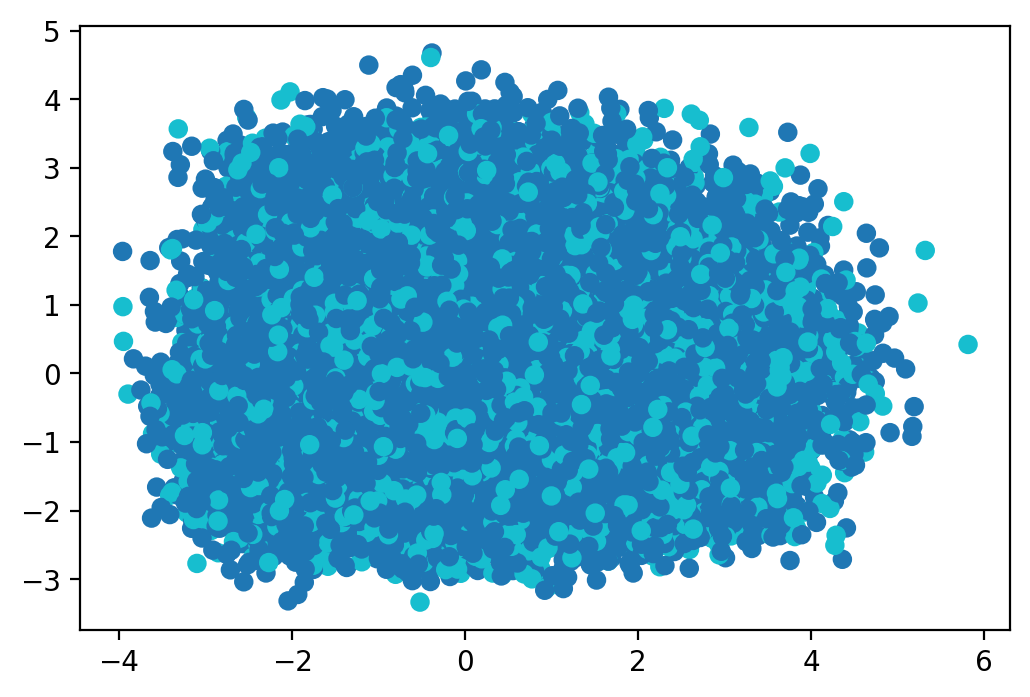

In [53]:
# Use PCA to look at the how the VAE encodes the training data in 2D.
# We look at the first to components below. 
pca = PCA(n_components=2) # Reduce dimension to 2. 

with torch.no_grad():
        for i, (x, y) in enumerate(train_data_loader): # Go through all batches of training data. 
            z = autoencoder.encoder(x.to(device))
            z = z.cpu().numpy()
            comps = pca.fit_transform(z)
            plt.scatter(comps[:, 0], comps[:, 1], c=y, cmap='tab10')
        plt.show() # Does not look good!

## This VAE obviously sucks and is nothing in comparison to the one in my project!

We need to fix it somehow, since I want it to work! Then I want to try to see what it does with two outputs, one for categorical and one for numerical. 

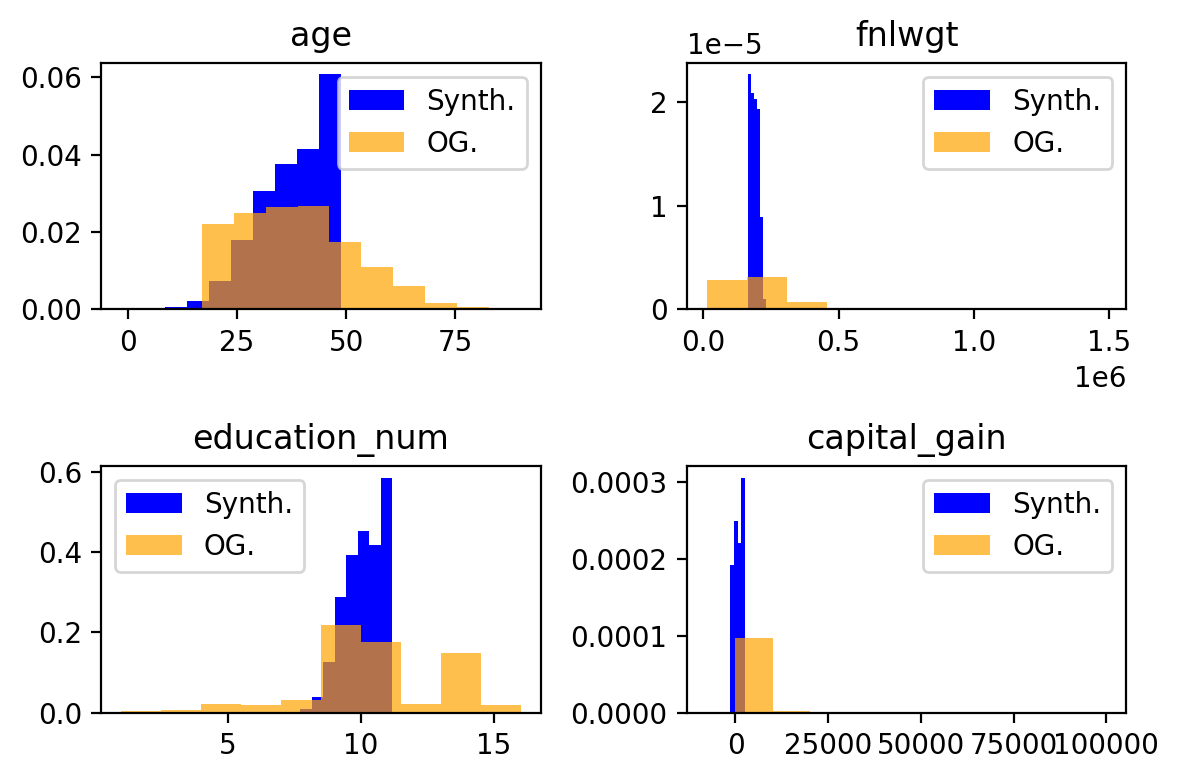

In [106]:
fig, axs = plt.subplots(2,2)
axs = axs.ravel()
for idx, ax in enumerate(axs):
    ax.hist(s_df_new[numerical_features[idx]], density = True, color = "b", label = "Synth.")
    ax.hist(adult_data[numerical_features[idx]], color = "orange", alpha = 0.7, density = True, label = "OG.")
    ax.legend()
    ax.title.set_text(numerical_features[idx])
plt.tight_layout()

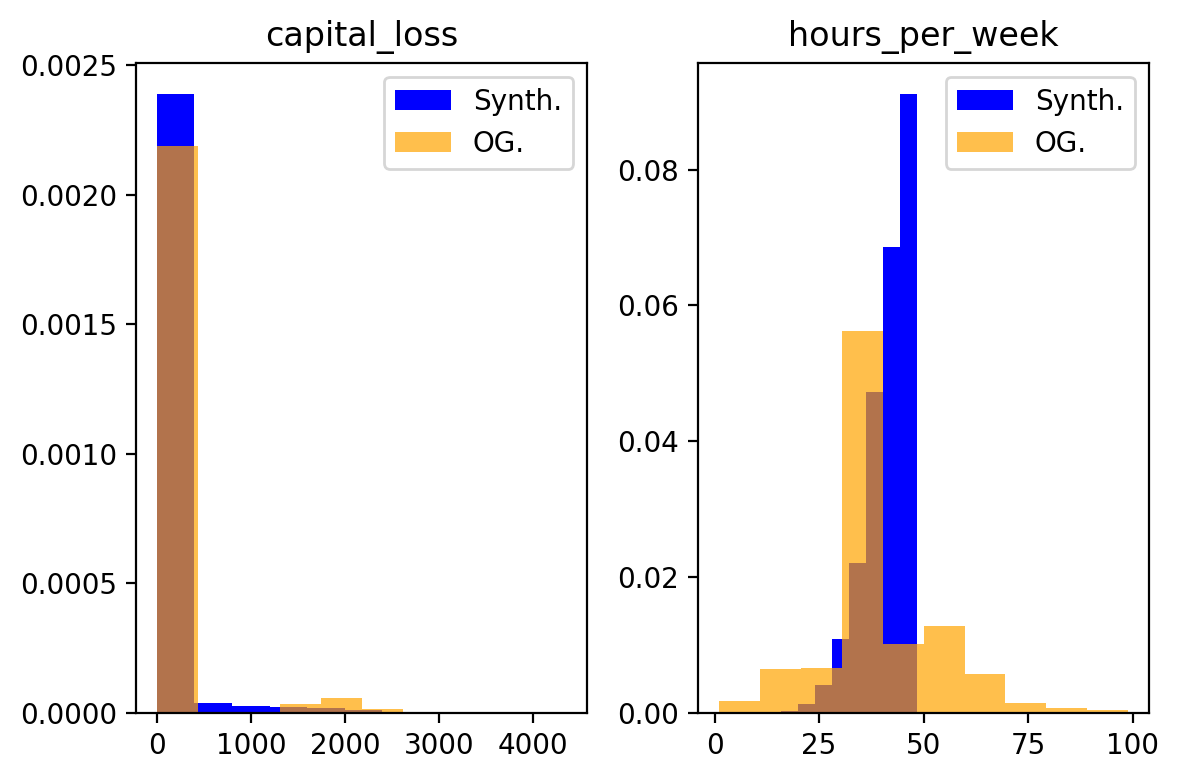

In [110]:
fig, axs = plt.subplots(1,2)
axs = axs.ravel()
for idx, ax in enumerate(axs, start = 4):
    ax.hist(s_df_new[numerical_features[idx]], density = True, color = "b", label = "Synth.")
    ax.hist(adult_data[numerical_features[idx]], color = "orange", alpha = 0.7, density = True, label = "OG.")
    ax.legend()
    ax.title.set_text(numerical_features[idx])
plt.tight_layout()

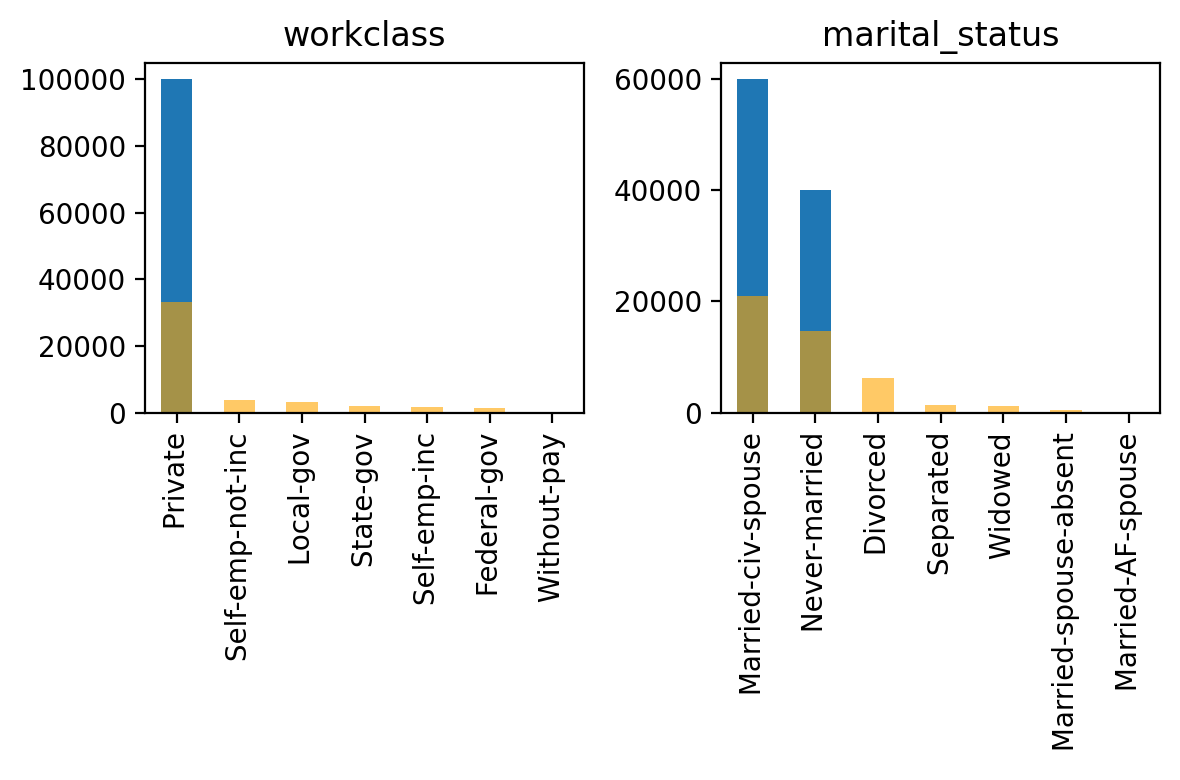

In [125]:
fig, axs = plt.subplots(1,2)
axs = axs.ravel()
for idx, ax in enumerate(axs):
    s_df_new[categorical_features[idx]].value_counts().plot(kind='bar', ax = ax)
    adult_data[categorical_features[idx]].value_counts().plot(kind='bar', ax = ax, color = "orange", alpha = 0.6)
    ax.title.set_text(categorical_features[idx])
plt.tight_layout()

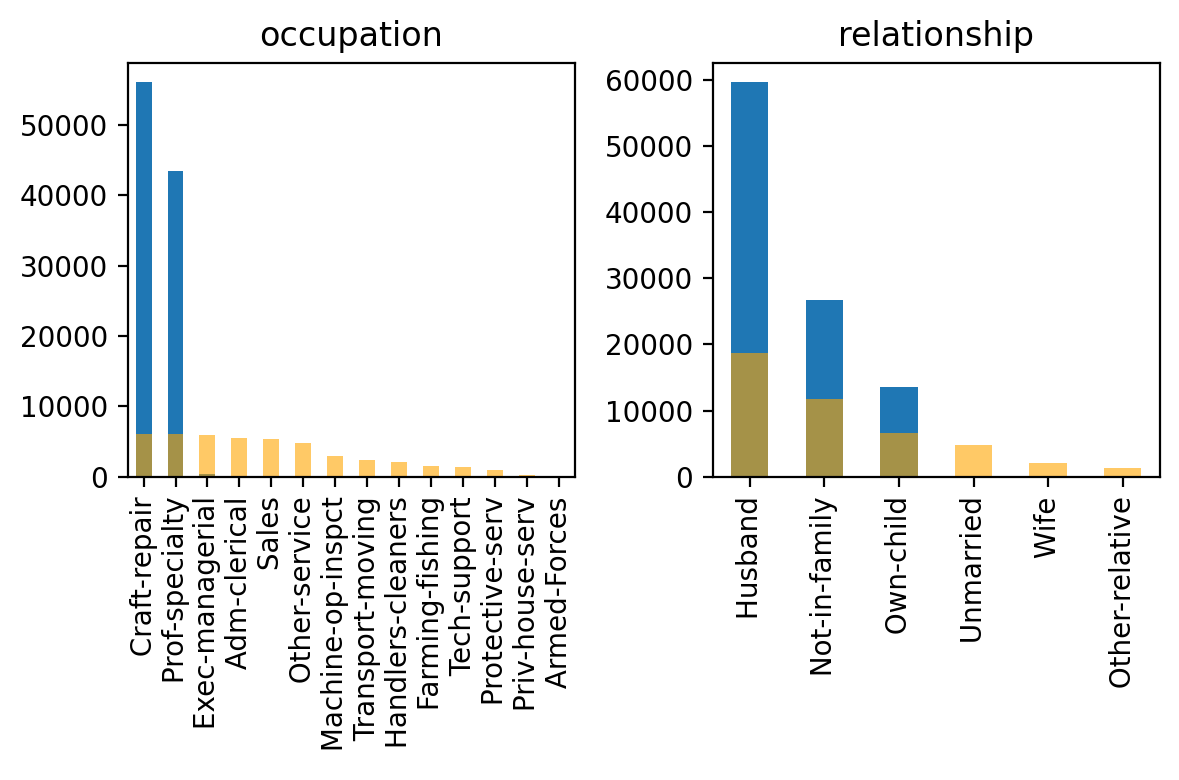

In [126]:
fig, axs = plt.subplots(1,2)
axs = axs.ravel()
for idx, ax in enumerate(axs, start = 2):
    s_df_new[categorical_features[idx]].value_counts().plot(kind='bar', ax = ax)
    adult_data[categorical_features[idx]].value_counts().plot(kind='bar', ax = ax, color = "orange", alpha = 0.6)
    ax.title.set_text(categorical_features[idx])
plt.tight_layout()

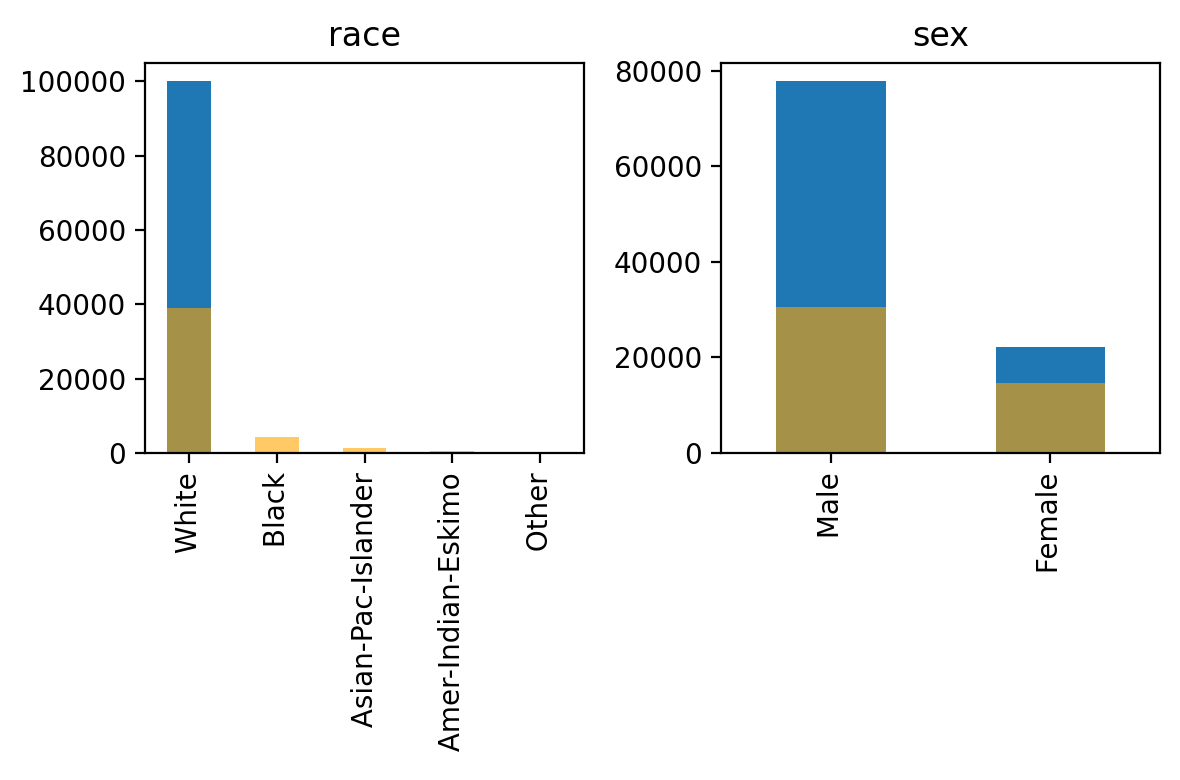

In [127]:
fig, axs = plt.subplots(1,2)
axs = axs.ravel()
for idx, ax in enumerate(axs, start = 4):
    s_df_new[categorical_features[idx]].value_counts().plot(kind='bar', ax = ax)
    adult_data[categorical_features[idx]].value_counts().plot(kind='bar', ax = ax, color = "orange", alpha = 0.6)
    ax.title.set_text(categorical_features[idx])
plt.tight_layout()

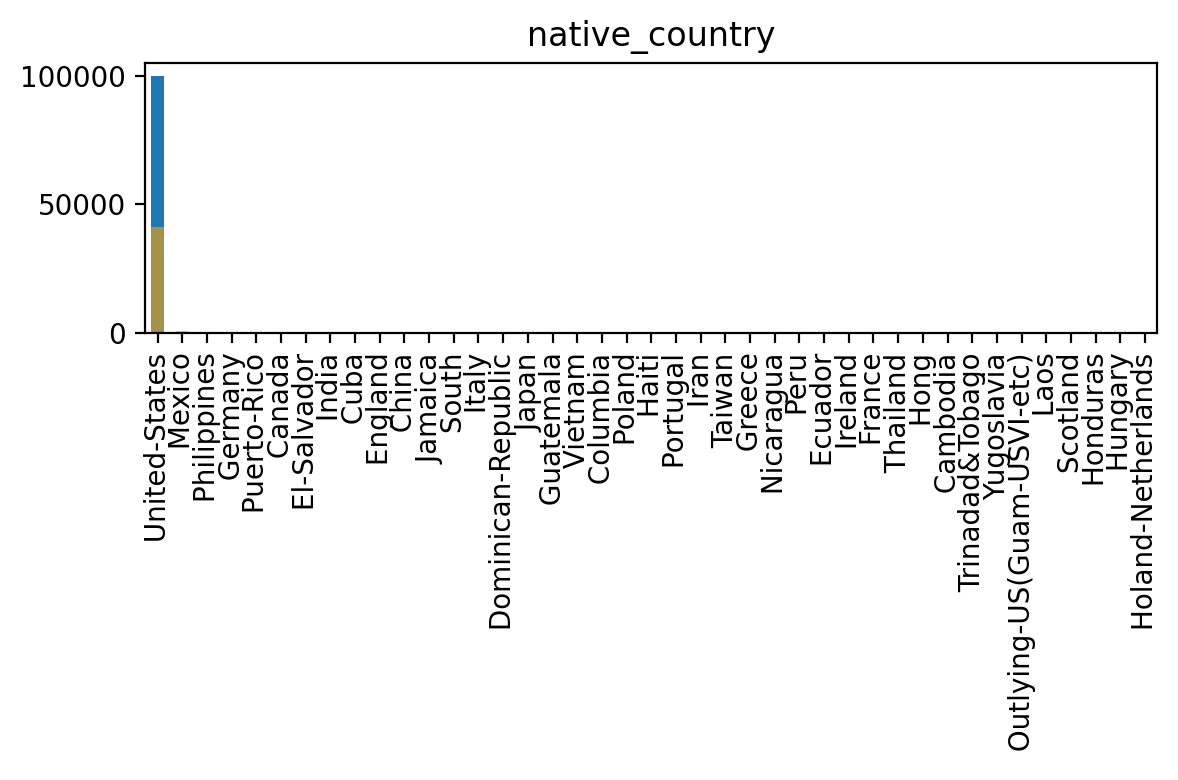

In [132]:
fig, axs = plt.subplots(1,1)
s_df_new[categorical_features[6]].value_counts().plot(kind='bar', ax = axs)
adult_data[categorical_features[6]].value_counts().plot(kind='bar', ax = axs, color = "orange", alpha = 0.6)
axs.title.set_text(categorical_features[6])
plt.tight_layout()